In [1]:
# general tools
import sys
from glob import glob

# data tools
import time
import h5py
import random
import numpy as np
from random import shuffle

import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
# deep learning tools
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
tf.config.run_functions_eagerly(True)

# from keras_unet_collection import models as k_models
from keras_unet_collection import utils as k_utils
# from keras_unet_collection import layer_utils as k_layers
# from keras_unet_collection.activations import GELU

2022-10-04 23:01:55.746805: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.10.1


In [3]:
sys.path.insert(0, '/glade/u/home/ksha/NCAR/')
sys.path.insert(0, '/glade/u/home/ksha/NCAR/libs/')

from namelist import *
import data_utils as du
import graph_utils as gu
import convnext_keras as ck

from sklearn.metrics import classification_report, auc, roc_curve
from sklearn.metrics import confusion_matrix

import matplotlib.pyplot as plt
%matplotlib inline

In [4]:
from importlib import reload
reload(ck)

<module 'convnext_keras' from '/glade/u/home/ksha/NCAR/libs/convnext_keras.py'>

In [5]:
glob("/glade/scratch/ksha/DATA/NCAR_batch/TRAIN*neg_neg_neg*lead1.npy")

[]

In [6]:
ind_pick_from_batch = [0, 3, 4, 8, 9, 10, 13, 14, 17, 18, 21, 22]
L_vars = len(ind_pick_from_batch)

In [7]:
filename_neg_train = sorted(glob("/glade/scratch/ksha/DATA/NCAR_batch/TRAIN*neg_neg_neg*lead2.npy")+\
                            glob("/glade/scratch/ksha/DATA/NCAR_batch/TRAIN*neg_neg_neg*lead3.npy")+\
                            glob("/glade/scratch/ksha/DATA/NCAR_batch/TRAIN*neg_neg_neg*lead4.npy"))

filename_pos_train = sorted(glob("/glade/scratch/ksha/DATA/NCAR_batch/TRAIN*pos*lead2.npy")+\
                            glob("/glade/scratch/ksha/DATA/NCAR_batch/TRAIN*pos*lead3.npy")+\
                            glob("/glade/scratch/ksha/DATA/NCAR_batch/TRAIN*pos*lead4.npy"))

filename_neg_valid = sorted(glob("/glade/scratch/ksha/DATA/NCAR_batch/VALID*neg_neg_neg*lead2.npy"))
filename_pos_valid = sorted(glob("/glade/scratch/ksha/DATA/NCAR_batch/VALID*pos*lead2.npy"))

In [8]:
filename_valid = filename_neg_valid[::50] + filename_pos_valid

In [9]:
len(filename_valid)

7058

In [10]:
with h5py.File(save_dir+'HRRR_domain.hdf', 'r') as h5io:
    lon_3km = h5io['lon_3km'][...]
    lat_3km = h5io['lat_3km'][...]
    lon_72km = h5io['lon_72km'][...]
    lat_72km = h5io['lat_72km'][...]
    land_mask_72km = h5io['land_mask_72km'][...]
    land_mask_3km = h5io['land_mask_3km'][...]

In [11]:
L_valid = len(filename_valid)
L_var = L_vars

TEST_input = np.empty((L_valid, 64, 64, L_var))
TEST_target = np.ones(L_valid)

for i, name in enumerate(filename_valid):
    data = np.load(name)
    for k, c in enumerate(ind_pick_from_batch):
        
        TEST_input[i, ..., k] = data[..., c]

        if 'pos' in name:
            TEST_target[i] = 1.0
        else:
            TEST_target[i] = 0.0

In [12]:
TEST_input.shape

(7058, 64, 64, 12)

In [13]:
np.sum(TEST_target) / len(TEST_target)

0.06432417115330122

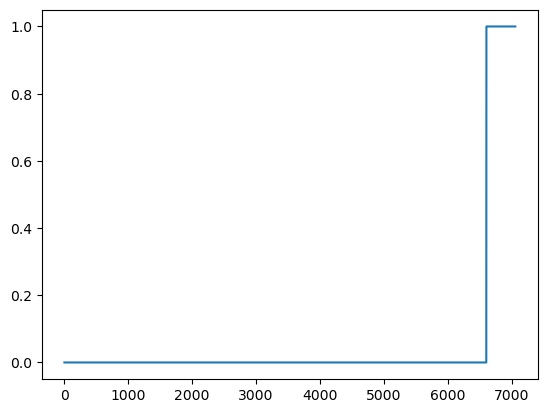

In [14]:
plt.plot(TEST_target)

**ConvNext**

In [15]:
import numpy as np
import tensorflow as tf
from tensorflow.keras import backend
from tensorflow.keras import layers
from tensorflow.keras import utils
from tensorflow.keras import Model

  
class LayerScale(layers.Layer):
    """Layer scale module.
    References:
      - https://arxiv.org/abs/2103.17239
    Args:
      init_values (float): Initial value for layer scale. Should be within
        [0, 1].
      projection_dim (int): Projection dimensionality.
    Returns:
      Tensor multiplied to the scale.
    """

    def __init__(self, init_values, projection_dim, **kwargs):
        super().__init__(**kwargs)
        self.init_values = init_values
        self.projection_dim = projection_dim

    def build(self, input_shape):
        self.gamma = tf.Variable(
            self.init_values * tf.ones((self.projection_dim,))
        )

    def call(self, x):
        return x * self.gamma

    def get_config(self):
        config = super().get_config()
        config.update(
            {
                "init_values": self.init_values,
                "projection_dim": self.projection_dim,
            }
        )
        return config
    


def Head(num_classes=1000, name=None):
    """Implementation of classification head of RegNet.
    Args:
      num_classes: number of classes for Dense layer
      name: name prefix
    Returns:
      Classification head function.
    """
    if name is None:
        name = str(backend.get_uid("head"))

    def apply(x):
        x = layers.GlobalAveragePooling2D(name=name + "_head_gap")(x)
        x = layers.LayerNormalization(
            epsilon=1e-6, name=name + "_head_layernorm"
        )(x)
        x = layers.Dense(num_classes, name=name + "_head_dense")(x)
        return x

    return apply


In [47]:
depths=[3, 3, 27, 3]
projection_dims=[96, 192, 384, 768]
drop_path_rate=0.0
layer_scale_init_value=1e-6
model_name='test'
input_shape=(64, 64, 12)
classes=1

IN = layers.Input(shape=input_shape)
X = IN

num_convnext_blocks = 4

# ----- convnext block 0 ----- #

X = layers.Conv2D(projection_dims[0], kernel_size=4, strides=4, name="{}_down0".format(model_name))(X)
X = layers.LayerNormalization(epsilon=1e-6, name="{}_down0_norm".format(model_name))(X)

for j in range(depths[0]):
    
    X_convnext = X
    X_convnext = layers.Conv2D(filters=projection_dims[0], kernel_size=7, padding="same",
                               groups=projection_dims[0], name="{}_down0_dconv{}".format(model_name, j))(X_convnext)
    X_convnext = layers.LayerNormalization(epsilon=1e-6, name="{}_down0_dconv{}_norm".format(model_name, j))(X_convnext)
    X_convnext = layers.Dense(4 * projection_dims[0], name="{}_down0_dense{}_p1".format(model_name, j))(X_convnext)
    X_convnext = layers.Activation("gelu", name="{}_down0_gelu{}".format(model_name, j))(X_convnext)
    X_convnext = layers.Dense(projection_dims[0], name="{}_down0_dense{}_p2".format(model_name, j))(X_convnext)

    X_convnext = LayerScale(layer_scale_init_value, projection_dims[0], name="{}_down0_layerscale{}".format(model_name, j))(X_convnext)

    X = X + X_convnext


# ----- convnext block 1 ----- #

X = layers.LayerNormalization(epsilon=1e-6, name="{}_down1_norm".format(model_name))(X)
X = layers.Conv2D(projection_dims[1], kernel_size=2, strides=2, name="{}_down1".format(model_name))(X)

for j in range(depths[1]):
    
    X_convnext = X
    X_convnext = layers.Conv2D(filters=projection_dims[1], kernel_size=7, padding="same",
                               groups=projection_dims[1], name="{}_down1_dconv{}".format(model_name, j))(X_convnext)
    X_convnext = layers.LayerNormalization(epsilon=1e-6, name="{}_down1_dconv{}_norm".format(model_name, j))(X_convnext)
    X_convnext = layers.Dense(4 * projection_dims[1], name="{}_down1_dense{}_p1".format(model_name, j))(X_convnext)
    X_convnext = layers.Activation("gelu", name="{}_down1_gelu{}".format(model_name, j))(X_convnext)
    X_convnext = layers.Dense(projection_dims[1], name="{}_down1_dense{}_p2".format(model_name, j))(X_convnext)

    X_convnext = LayerScale(layer_scale_init_value, projection_dims[1], name="{}_down1_layerscale{}".format(model_name, j))(X_convnext)

    X = X + X_convnext

# ----- convnext block 2 ----- #

X = layers.LayerNormalization(epsilon=1e-6, name="{}_down2_norm".format(model_name))(X)
X = layers.Conv2D(projection_dims[2], kernel_size=2, strides=2, name="{}_down2".format(model_name))(X)

for j in range(depths[2]):
    
    X_convnext = X
    X_convnext = layers.Conv2D(filters=projection_dims[2], kernel_size=7, padding="same",
                               groups=projection_dims[2], name="{}_down2_dconv{}".format(model_name, j))(X_convnext)
    X_convnext = layers.LayerNormalization(epsilon=1e-6, name="{}_down2_dconv{}_norm".format(model_name, j))(X_convnext)
    X_convnext = layers.Dense(4 * projection_dims[2], name="{}_down2_dense{}_p1".format(model_name, j))(X_convnext)
    X_convnext = layers.Activation("gelu", name="{}_down2_gelu{}".format(model_name, j))(X_convnext)
    X_convnext = layers.Dense(projection_dims[2], name="{}_down2_dense{}_p2".format(model_name, j))(X_convnext)

    X_convnext = LayerScale(layer_scale_init_value, projection_dims[2], name="{}_down2_layerscale{}".format(model_name, j))(X_convnext)

    X = X + X_convnext

# ----- convnext block 3 ----- #

X = layers.LayerNormalization(epsilon=1e-6, name="{}_down3_norm".format(model_name))(X)
X = layers.Conv2D(projection_dims[3], kernel_size=2, padding='same', name="{}_down3".format(model_name))(X)

for j in range(depths[3]):
    
    X_convnext = X
    X_convnext = layers.Conv2D(filters=projection_dims[3], kernel_size=7, padding="same",
                               groups=projection_dims[3], name="{}_down3_dconv{}".format(model_name, j))(X_convnext)
    X_convnext = layers.LayerNormalization(epsilon=1e-6, name="{}_down3_dconv{}_norm".format(model_name, j))(X_convnext)
    X_convnext = layers.Dense(4 * projection_dims[3], name="{}_down3_dense{}_p1".format(model_name, j))(X_convnext)
    X_convnext = layers.Activation("gelu", name="{}_down3_gelu{}".format(model_name, j))(X_convnext)
    X_convnext = layers.Dense(projection_dims[3], name="{}_down3_dense{}_p2".format(model_name, j))(X_convnext)

    X_convnext = LayerScale(layer_scale_init_value, projection_dims[3], name="{}_down3_layerscale{}".format(model_name, j))(X_convnext)

    X = X + X_convnext

OUT = X

OUT = layers.GlobalMaxPooling2D(name="{}_head_pool".format(model_name))(OUT)
OUT = layers.LayerNormalization(epsilon=1e-6, name="{}_head_norm".format(model_name))(OUT)

OUT = layers.Dense(128, name="{}_dense1".format(model_name))(OUT)
OUT = layers.LayerNormalization(epsilon=1e-6, name="{}_dense1_norm".format(model_name))(OUT)
OUT = layers.Activation("gelu", name="{}_dense1_gelu{}".format(model_name, j))(OUT)

OUT = layers.Dense(1, name="{}_head_out".format(model_name))(OUT)

model = Model(inputs=IN, outputs=OUT, name=model_name)

In [48]:
from sklearn.metrics import brier_score_loss
from sklearn.metrics import log_loss


def verif_metric(VALID_target, Y_pred):


    # fpr, tpr, thresholds = roc_curve(VALID_target.ravel(), Y_pred.ravel())
    # AUC = auc(fpr, tpr)
    # AUC_metric = 1 - AUC
    
    BS = np.mean((VALID_target.ravel() - Y_pred.ravel())**2)
    #ll = log_loss(VALID_target.ravel(), Y_pred.ravel())
    
    print('{}'.format(BS))
    metric = BS

    return metric

In [49]:
tol = 0
min_del = 0
max_tol = 500 # early stopping with patience

epochs = 500
L_train = 64
batch_size = 100

batch_size_half = 50

valid_size = 1

In [62]:
batch_dir = '/glade/scratch/ksha/DATA/NCAR_batch/'
temp_dir = '/glade/work/ksha/NCAR/Keras_models/'

key = 'FC_12_Lead2'

model_name = '{}_pp23_tune'.format(key)
model_path = temp_dir+model_name

W_old = k_utils.dummy_loader(temp_dir+'FC_12_Lead2_pp23')
model.set_weights(W_old)


In [63]:
model.compile(loss=keras.losses.mean_absolute_error, optimizer=keras.optimizers.Adam(lr=1e-5))
#keras.losses.BinaryCrossentropy(from_logits=True)

In [64]:
X_batch = np.empty((batch_size, 64, 64, L_vars))
Y_batch = np.empty((batch_size, 1))
X_batch[...] = np.nan
Y_batch[...] = np.nan

In [65]:
Y_pred = model.predict([TEST_input,])

In [66]:
# save_dict = {}
# save_dict['y_true'] = TEST_target
# save_dict['y_pred'] = Y_pred

# np.save("ALL_pred_lead2.npy", save_dict)

In [67]:
# Y_pred[Y_pred<0] = 0
# Y_pred[Y_pred>1] = 1
record = verif_metric(TEST_target, Y_pred)
print("Initial record: {}".format(record))

0.033225374827617206
Initial record: 0.033225374827617206


In [68]:
# 0.034775568168985756
# Initial record: 0.034775568168985756

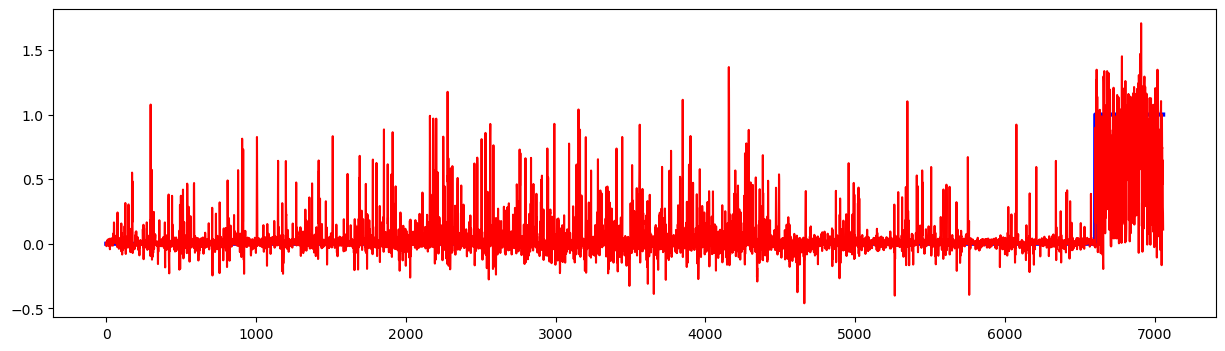

In [69]:
plt.figure(figsize=(15, 4))
plt.plot(TEST_target, 'b-', lw=3.0)
plt.plot(Y_pred, 'r-')
#plt.plot(Y_pred>0.5)

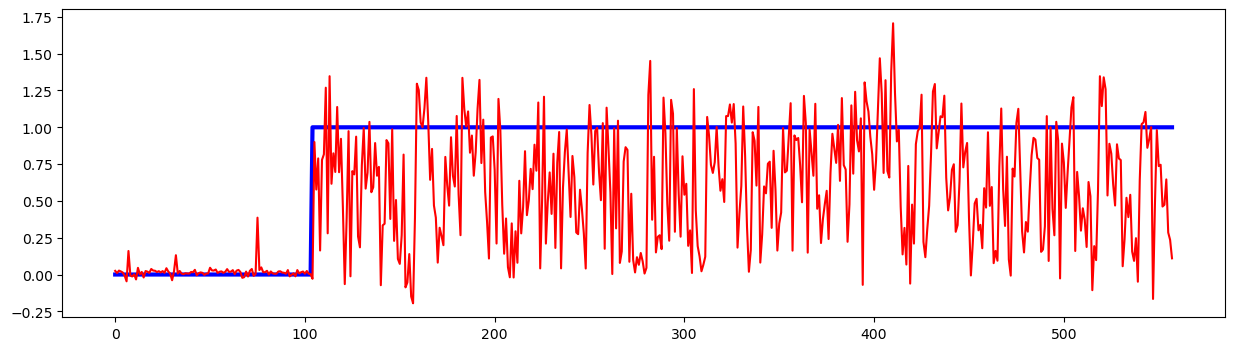

In [70]:
plt.figure(figsize=(15, 4))
plt.plot(TEST_target[6500:], 'b-', lw=3.0)
plt.plot(Y_pred[6500:], 'r-')
#plt.plot(Y_pred>0.5)

In [71]:
# plt.pcolormesh(TEST_input[3154, ..., 2], cmap=plt.cm.nipy_spectral_r)
# plt.colorbar()

In [72]:
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [73]:
# ========== Training loop ========== #
L_storm = len(filename_neg_train)
L_aug = len(filename_pos_train)

for i in range(epochs):
    
    shuffle(filename_neg_train)
    shuffle(filename_pos_train)
    
    #print('epoch = {}'.format(i))
    start_time = time.time()
    
    # loop of batch
    for j in range(L_train):
        
        #N_aug = int(np.random.uniform(2, 7))
        N_aug = int(np.random.uniform(8, 14))
        #N_aug = int(np.random.uniform(10, 25))
        #N_aug = int(np.random.uniform(20, 45))
        
        N_storm = 100 - N_aug
        
        ind_storm = du.shuffle_ind(L_storm)
        ind_aug = du.shuffle_ind(L_aug)
        
        file_pick_storm = []
        for ind_temp in ind_storm[:N_storm]:
            file_pick_storm.append(filename_neg_train[ind_temp])

        file_pick_aug = []
        for ind_temp in ind_aug[:N_aug]:
            file_pick_aug.append(filename_pos_train[ind_temp])
        
        file_pick = file_pick_storm + file_pick_aug
        
        if len(file_pick) != 100:
            sregwet
        
        for k in range(batch_size):

            data = np.load(file_pick[k])
            
            for l, c in enumerate(ind_pick_from_batch):
            
                X_batch[k, ..., l] = data[..., c]
            
            if 'pos' in file_pick[k]:
                Y_batch[k, :] = 1.0 #np.random.uniform(0.9, 0.99)
            elif 'neg_neg_neg' in file_pick[k]:
                Y_batch[k, :] = 0.0 #np.random.uniform(0.01, 0.05)
            else:
                werhgaer
                
        #Y_batch_cate = tf.keras.utils.to_categorical(Y_batch)
        
        # # add noise within sparse inputs
        # for v in flag_sparse:
        #     X_batch[..., v] += np.random.uniform(0, 0.01, size=(batch_size, 128, 128))

        # shuffle indices
        ind_ = du.shuffle_ind(batch_size)
        X_batch = X_batch[ind_, ...]
        Y_batch = Y_batch[ind_, :]
        
        if np.sum(np.isnan(X_batch)) > 0:
            asfeargagqarew
        
        # train on batch
        model.train_on_batch([X_batch,], [Y_batch,]);
    
    # epoch end operations
    Y_pred = model.predict([TEST_input,])
    # Y_pred[Y_pred<0] = 0
    # Y_pred[Y_pred>1] = 1
    record_temp = verif_metric(TEST_target, Y_pred)
    
    # if i % 10 == 0:
    #     model.save(model_path_backup)
    
    if (record - record_temp > min_del) and (np.max(Y_pred) > 0.6):
        print('Validation loss improved from {} to {}'.format(record, record_temp))
        record = record_temp
        tol = 0
        #print('tol: {}'.format(tol))
        # save
        print('save to: {}'.format(model_path))
        model.save(model_path)
    else:
        print('Validation loss {} NOT improved'.format(record_temp))
        tol += 1
        #print('tol: {}'.format(tol))
        if tol >= max_tol:
            print('Early stopping')
            sys.exit();
        else:
            #print('Pass to the next epoch')
            continue;
    print("--- %s seconds ---" % (time.time() - start_time))

0.033469814027354244
Validation loss 0.033469814027354244 NOT improved
0.03462234827867743
Validation loss 0.03462234827867743 NOT improved
0.0331461961715414
Validation loss improved from 0.033225374827617206 to 0.0331461961715414
save to: /glade/work/ksha/NCAR/Keras_models/FC_12_Lead2_pp23_tune
INFO:tensorflow:Assets written to: /glade/work/ksha/NCAR/Keras_models/FC_12_Lead2_pp23_tune/assets
--- 215.1545159816742 seconds ---


/glade/work/ksha/anaconda3/lib/python3.9/site-packages/tensorflow/python/data/ops/dataset_ops.py:3503: UserWarning: Even though the tf.config.experimental_run_functions_eagerly option is set, this option does not apply to tf.data functions. tf.data functions are still traced and executed as graphs.
  warnings.warn(


0.03416818788857578
Validation loss 0.03416818788857578 NOT improved
0.03338531244872175
Validation loss 0.03338531244872175 NOT improved
0.032718396227252894
Validation loss improved from 0.0331461961715414 to 0.032718396227252894
save to: /glade/work/ksha/NCAR/Keras_models/FC_12_Lead2_pp23_tune
INFO:tensorflow:Assets written to: /glade/work/ksha/NCAR/Keras_models/FC_12_Lead2_pp23_tune/assets
--- 211.60160064697266 seconds ---


/glade/work/ksha/anaconda3/lib/python3.9/site-packages/tensorflow/python/data/ops/dataset_ops.py:3503: UserWarning: Even though the tf.config.experimental_run_functions_eagerly option is set, this option does not apply to tf.data functions. tf.data functions are still traced and executed as graphs.
  warnings.warn(


0.032906246086133455
Validation loss 0.032906246086133455 NOT improved
0.03286003500614006
Validation loss 0.03286003500614006 NOT improved
0.03384012221432585
Validation loss 0.03384012221432585 NOT improved
0.03331316200439186
Validation loss 0.03331316200439186 NOT improved
0.03254814010922241
Validation loss improved from 0.032718396227252894 to 0.03254814010922241
save to: /glade/work/ksha/NCAR/Keras_models/FC_12_Lead2_pp23_tune
INFO:tensorflow:Assets written to: /glade/work/ksha/NCAR/Keras_models/FC_12_Lead2_pp23_tune/assets
--- 206.8943521976471 seconds ---


/glade/work/ksha/anaconda3/lib/python3.9/site-packages/tensorflow/python/data/ops/dataset_ops.py:3503: UserWarning: Even though the tf.config.experimental_run_functions_eagerly option is set, this option does not apply to tf.data functions. tf.data functions are still traced and executed as graphs.
  warnings.warn(


0.0334598738479951
Validation loss 0.0334598738479951 NOT improved
0.0326865640467543
Validation loss 0.0326865640467543 NOT improved
0.03379578599605179
Validation loss 0.03379578599605179 NOT improved
0.033241406203840466
Validation loss 0.033241406203840466 NOT improved
0.03342474650267826
Validation loss 0.03342474650267826 NOT improved
0.032908879801649346
Validation loss 0.032908879801649346 NOT improved
0.03336674603007158
Validation loss 0.03336674603007158 NOT improved
0.032692264910327395
Validation loss 0.032692264910327395 NOT improved
0.03297642335265449
Validation loss 0.03297642335265449 NOT improved
0.03313984769390772
Validation loss 0.03313984769390772 NOT improved
0.033331275683902754
Validation loss 0.033331275683902754 NOT improved
0.03399533235327491
Validation loss 0.03399533235327491 NOT improved
0.032484043260006666
Validation loss improved from 0.03254814010922241 to 0.032484043260006666
save to: /glade/work/ksha/NCAR/Keras_models/FC_12_Lead2_pp23_tune
INFO:te

/glade/work/ksha/anaconda3/lib/python3.9/site-packages/tensorflow/python/data/ops/dataset_ops.py:3503: UserWarning: Even though the tf.config.experimental_run_functions_eagerly option is set, this option does not apply to tf.data functions. tf.data functions are still traced and executed as graphs.
  warnings.warn(


0.03304454108547681
Validation loss 0.03304454108547681 NOT improved
0.03327744317588739
Validation loss 0.03327744317588739 NOT improved
0.032654965948286326
Validation loss 0.032654965948286326 NOT improved
0.03292339181120151
Validation loss 0.03292339181120151 NOT improved
0.03317825331794092
Validation loss 0.03317825331794092 NOT improved
0.03368343723486624
Validation loss 0.03368343723486624 NOT improved
0.032600820510226856
Validation loss 0.032600820510226856 NOT improved
0.03348899274242647
Validation loss 0.03348899274242647 NOT improved
0.032770473976127056
Validation loss 0.032770473976127056 NOT improved
0.03293930160490811
Validation loss 0.03293930160490811 NOT improved
0.03339600829038423
Validation loss 0.03339600829038423 NOT improved
0.0330085194715094
Validation loss 0.0330085194715094 NOT improved
0.03300607177188942
Validation loss 0.03300607177188942 NOT improved
0.033253867469611974
Validation loss 0.033253867469611974 NOT improved
0.03321321273878005
Validati

KeyboardInterrupt: 

In [38]:
j

123844

In [ ]:
https://mesonet.agron.iastate.edu/pickup/wwa/

In [29]:
10 % 3

1